# Lab 2: Central Pattern Generator (CPG): Degeneracy and Robustness

In this lab, we will move from simple motifs to actual small circuit in which we retain the key features of a network degeneracy and robustness regarding behaviors like pattern generation. 

(Code by Lihao Guo, Questions by Arvind Kumar 2022. The tutorial is inspired by work of Prinz et al., 2004 Nat. Neuroscience)

In [ ]:
#@title Run the following to initialize lab environment.
debug = 'google.colab' not in str(get_ipython())
if not debug:
    import os, sys

    # clone respository
    user = "michaelglh"
    repo = "STG"
    if os.path.isdir(repo):
        !rm -rf {repo}
    !git clone https://github.com/{user}/{repo}.git

    # add path to system
    src_dir = ""
    path = f"{repo}/{src_dir}"
    if not path in sys.path:
        sys.path.insert(1, path)

    from google.colab import output
    output.enable_custom_widget_manager()

    !pip install ipympl==0.8.0 --quiet

    import matplotlib.backends

In [14]:
#@title Run the following to download necessary files.
from lib.neuron import LIF
from lib.input import Poisson_generator, Gaussian_generator, Current_injector
from lib.conn import Simulator
from lib.helper import plot_volt_trace, pair_volt_trace
    
import matplotlib.pyplot as plt         # import matplotlib
import numpy as np                      # import numpy
import ipywidgets as widgets            # interactive display
my_layout = widgets.Layout()

# setting for figures
fig_w, fig_h = 8, 6
my_fontsize = 18
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': (fig_w, fig_h),
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}

plt.rcParams.update(my_params)

# Auto Reloading
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Different types of synapses
In the following we connected two neurons with an excitatory synapses. The synapse can be 


*   Static: The synaptic weight (amplitude) remains constant irrespective of the input rate
*   Short-term facilitation: The synaptic weight increases with every spike. The increase is dependent on the firing rate of the pre-synaptic neuron.
*   Short-term depression: The synaptic weight decreases with every spike. The decrease is dependent on the firing rate of the pre-synaptic neuron.

Finally, we have a gap junction between the two neurons. To appreciate the gap junction we will plot the membrane potential of the two neuron against each other. 

The presynaptic neurons is driven by direct current and it spikes in a regular fashion.

interactive(children=(Dropdown(description='c_ie', options=('Static', 'Faci', 'Depr', 'Gap'), value='Static'),…

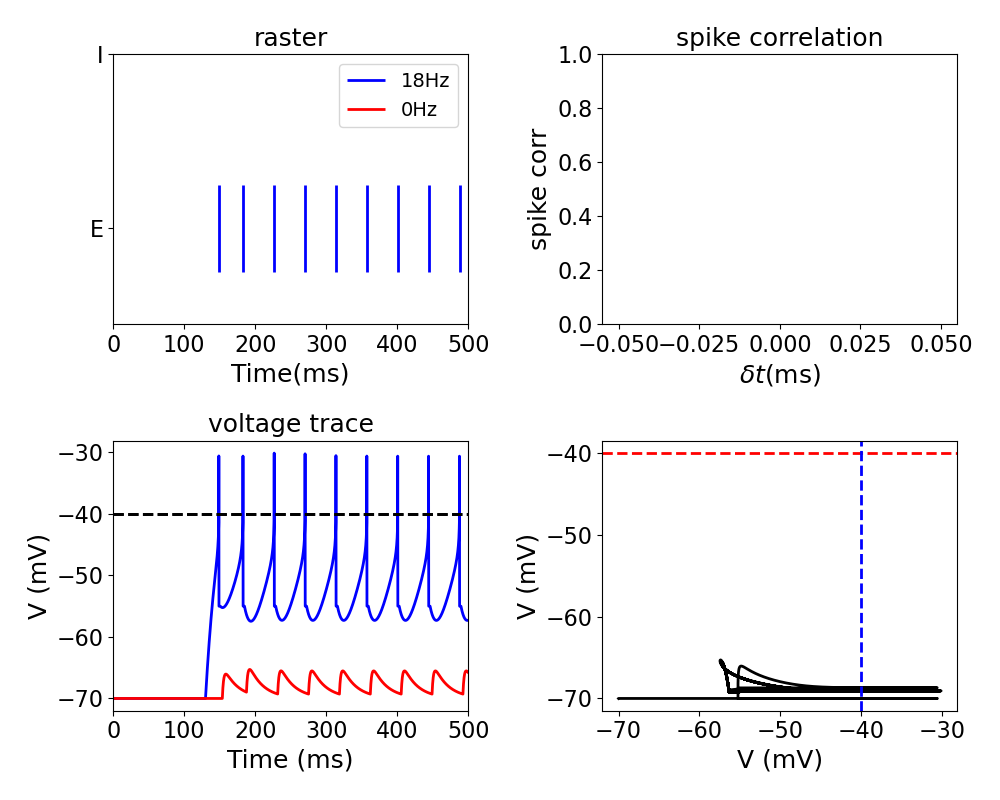

In [15]:
#@title Run the following to start single neuron simulation { vertical-output: true }
T, dt = 5e2, 0.1        # simulation period(ms), step size(ms)
rt = 80.
N = 2                  # number of neurons

# neuron types
tonic_neuron = {'tau_m':20., 'a':0., 'tau_w':30., 'b':3., 'V_reset':-55.}
adapting_neuron = {'tau_m':20., 'a':0., 'tau_w':100., 'b':0.5, 'V_reset':-55.}
initburst_neuron = {'tau_m':10., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-50.}
bursting_neuron = {'tau_m':5., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-46.}
irregular_neuron = {'tau_m':10., 'a':-0.01, 'tau_w':50., 'b':1.2, 'V_reset':-46.}
transient_neuron = {'tau_m':5., 'a':0.05, 'tau_w':100., 'b':0.7, 'V_reset':-60.}
delayed_neuron = {'tau_m':5., 'a':-0.1, 'tau_w':100., 'b':1., 'V_reset':-60.}
rebound_neuron = {'tau_m':5., 'a':0.2, 'tau_w':150., 'b':0.1, 'V_reset':-54.}

neuron_params = {'tonic_neuron': tonic_neuron, 'adapting_neuron': adapting_neuron, 
                 'initburst_neuron': initburst_neuron, 'bursting_neuron': bursting_neuron, 
                 'irregular_neuron': irregular_neuron, 'transient_neuron': transient_neuron, 
                 'delayed_neuron': delayed_neuron, 'rebound_neuron': rebound_neuron}

# connection types
Ctypes = ['Static', 'Faci', 'Depr', 'Gap']

# updating parameters
def update_EI(c_ie='Static'):
    # simualtor
    h = Simulator(dt=dt)

    # network of neurons
    nrns = [LIF(sim=h) for _ in range(N)]
    for nrn in nrns:
        nrn.update(tonic_neuron)

    # background noise
    noise = Current_injector(sim=h, rate=rt, start=int(T/dt*0.25), end=int(T/dt))
    nrns[0].connect(noise, {'ctype':'Static', 'weight':1., 'delay':5.})      

    # recurrent connections
    tps = [['Static' for _ in range(N)] for _ in range(N)]
    if c_ie == 'Gap':
        J_ie = J_ei = 3
        tps[0][1] = tps[1][0] = c_ie
    else:
        J_ie = 0.5
        J_ei = 0.
        tps[1][0] = c_ie
    con = np.array([[0., J_ei],
                    [J_ie, 0.]])
    dly = np.random.uniform(2., 5., (N,N))
    synspecs = [[{} for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
    h.connect(nrns, nrns, synspecs)

    # simulation
    h.run(T)

    # coincidence
    binwindow = int(5.0/dt)
    spike_trains = [nrn.states for nrn in nrns]
    bin_spikes = [np.convolve(strain, np.ones(binwindow), 'same') for strain in spike_trains]
    deltats = np.linspace(-10., 10., 21)
    coins = []
    for delay in deltats:
        index = int(delay/dt)
        if index > 0:
            coins.append(np.dot(bin_spikes[0][:-index], bin_spikes[1][index:]))
        elif index < 0:
            coins.append(np.dot(bin_spikes[1][:index], bin_spikes[0][-index:]))
        else:
            coins.append(np.dot(bin_spikes[0], bin_spikes[1]))
    with np.errstate(divide='ignore', invalid='ignore'):
        coins = np.divide(np.array(coins), np.sqrt(np.dot(bin_spikes[0], bin_spikes[0]))*np.sqrt(np.dot(bin_spikes[1], bin_spikes[1])))

    # visualize
    plt.clf()
    cs = ['b', 'r']
    plt.subplot(2,N,1)
    plt.title('raster')
    for nrn, c, l in zip(nrns, cs, range(N)):
        plt.eventplot(nrn.spikes['times'], lineoffsets=2*l, colors=c, label='%dHz'%(len(nrn.spikes['times'])/T*1e3))
    plt.xlabel('Time(ms)')
    plt.yticks([0, 2], ['E', 'I'])
    plt.xlim([0., T])
    plt.legend()

    plt.subplot(2,N,2)
    plt.title('spike correlation')
    plt.plot(deltats, coins)
    plt.xlabel(r'$\delta t$(ms)')
    plt.ylabel('spike corr')
    plt.ylim([0, 1])

    # voltage traces
    plt.subplot(2,N,N+1)
    for id, c in zip(range(N), cs):
        if id == 0:
            plt.title('voltage trace')
        plt_par = {'dt':dt, 'range_t':np.arange(0., T, dt), 'V_th':nrns[id].V_th}
        plot_volt_trace(plt_par, nrns[id].v, np.array(nrns[id].spikes['times']), c=c)
        plt.xlim([0., T])

    # gap junction
    plt.subplot(2,N,N+2)
    plt_par = {'dt':dt, 'V_ths':[nrn.V_th for nrn in nrns]}
    pair_volt_trace(plt_par, [nrn.v for nrn in nrns], [np.array(nrn.spikes['times']) for nrn in nrns])
    plt.tight_layout()

fig_EI, axes = plt.subplots(2,N,figsize=(5*N,8))
widgets.interact(update_EI, c_ie=Ctypes);

### Constructing the pyloric circuit
In the following code we will realize the pyloric rhythm generator using our simplified neurons. Your goal is to find the right combination of connection weights that generate the desired pyloric rhythm shown in the right panel of the figure below.(Adapted from Eugene M. Izhikevich)

<img src="https://github.com/michaelglh/STG/blob/master/figs/pyloric_con.png?raw=1" alt="Pyloric circuit" width="1200"/>

In [ ]:
#@title Run the following to start pyloric circuit simulation { vertical-output: true }
# experiment setting
T, dt = 5e2, 0.1        # simulation period(ms), step size(ms)

# neurons
nrn_labels = ['AB', 'VD', 'IC', 'PD', 'LP', 'PY']
N = len(nrn_labels)
nrn_types = ['bursting_neuron']*N
rt = 50.
wts = [1.0]*N

# widget
grid = widgets.GridspecLayout(N+1, N+1)
signs = np.array([  [0 , 1 , 0 , 1 , 0 , 0],
                    [-1, 0 , -1, 0 , -1, 0],
                    [-1, -1, 0 , -1, 0 , -1],
                    [1 , 1 , 0 , 0 , -1, 0],
                    [-1, -1, 0 , -1, 0 , -1],
                    [-1, -1, 0 , -1, -1, 0]])
wsize = '200px'
for i, label in enumerate(nrn_labels):
    grid[0, i+1] = widgets.Text(value=label, disabled=True, layout=widgets.Layout(width=wsize))
for i, label in enumerate(nrn_labels):
    grid[i+1, 0] = widgets.Text(value=label, disabled=True, layout=widgets.Layout(width=wsize))
grid[0,0] = widgets.Text(value='J', disabled=True, layout=widgets.Layout(width=wsize))
for i in range(N):
    for j in range(N):
        if signs[i,j] != 0:
            grid[i+1,j+1] = widgets.FloatSlider(min=-10.0, max=-0.0, step=0.01, layout=widgets.Layout(width=wsize))
        else:
            grid[i+1,j+1] = widgets.Text(value='0', disabled=True, layout=widgets.Layout(width=wsize))

con_bars = {}
for i, tar in enumerate(nrn_labels):
    for j, src in enumerate(nrn_labels):
        con_bars['J_%s_%s'%(tar, src)] = grid[i+1,j+1]
con_pyloric = None

# updating parameters
indices = [0, 1, 2, 5, 4, 3]
nrn_ticks = [nrn_labels[i] for i in indices] + ['lvn']
def update_pyloric(**con_dict):
    # simualtor
    h = Simulator(dt=dt)

    # network of neurons
    nrns = [LIF(sim=h) for _ in range(N)]
    for nrn, label, ntype in zip(nrns, nrn_labels, nrn_types):
        nrn.name = label
        nrn.update(neuron_params[ntype])

    # background noise
    noises = [Current_injector(sim=h, rate=rt, start=0, end=int(T/dt)) for _ in range(N)]
    for noise, nrn, wt in zip(noises, nrns, wts):
        nrn.connect(noise, {'ctype':'Static', 'weight':wt})

    # recurrent connections
    tps = [['Static' for _ in range(N)] for _ in range(N)]
    con = np.reshape(np.array(list(con_dict.values()), dtype=float), (N,N))
    global con_pyloric
    con_pyloric = con_dict
    for i in range(N):
        for j in range(N):
            if signs[i][j] > 0:
                tps[i][j] = 'Gap'
            else:
                tps[i][j] = 'Static'
    dly = np.random.uniform(2., 5., (N,N))
    synspecs = [[{} for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
    h.connect(nrns, nrns, synspecs)

    # simulation
    h.run(T)

    # visualization
    cs = ['k', 'k', 'k', 'b', 'r', 'g']
    plt.clf()
    plt.title('pyloric')
    for nrn, c, l in zip(nrns, cs, indices):
        plt.eventplot(nrn.spikes['times'], lineoffsets=2*l, colors=c)
    for idx in [5, 4, 3]:
        plt.eventplot(nrns[idx].spikes['times'], lineoffsets=2*N, colors=cs[idx])
    plt.xlabel('Time(ms)')
    plt.yticks(list(np.arange(N+1)*2), nrn_ticks)
    plt.xlim([0., T])
    plt.tight_layout()

fig_pyloric = plt.figure(figsize=(8,8))
widget_pyloric = widgets.interactive_output(update_pyloric, con_bars);
display(grid, widget_pyloric);

## To Do:
Ask the other classmates (at least 3) for the parameters they found to obtain the near desired response in the pyloric circuit. Do their parameter values match with yours? If not, how much is the difference?

## Think
* Why is that each one of the students is finding somewhat different parameters for the near same circuit output?
* Can we compare these different solutions in some way so we can determine which parameter set is better? Or in your opinion, does this difference not matter?

### Robustness of pyloric rhythm
In the previous exercise you found one or more parameter set(s) that generated a near desired pattern of activity in the pyloric circuit. In the following exercise we will test the robustness of your model.
 
There are many ways to test the robustness of a model. Here we will use the most intuitive experiential approach. First we will fix the connectivity that you have found and you can vary the
* Input current
* Change the type of a specific neuron
* Change the weight of a specific synapse

In [ ]:
#@title Run the following to start pyloric circuit simulation { vertical-output: true }
# experiment setting
Itypes = ['Icur', 'Gaussian', 'Poisson']

con_valid = ['None']
for key, value in con_pyloric.items():
    if type(value) is float:
        con_valid.append(key)

def update_degtype(Itype='Icur', neuron='None', neurontype='bursting', conname='None', weight=-0.0):
    # simualtor
    h = Simulator(dt=dt)

    # network of neurons
    nrns = [LIF(sim=h) for _ in range(N)]
    for nrn, label, ntype in zip(nrns, nrn_labels, nrn_types):
        nrn.name = label
        if label == neuron:
            nrn.update(neuron_params[neurontype])
        else:
            nrn.update(neuron_params[ntype])
    # background noise
    if Itype == 'Icur':
        noises = [Current_injector(sim=h, rate=rt, start=0, end=int(T/dt)) for _ in range(N)]
    elif Itype == 'Gaussian':
        noises = [Gaussian_generator(sim=h, mean=rt, std=rt) for _ in range(N)]
    elif Itype == 'Poisson':
        noises = [Poisson_generator(sim=h, rate=150) for _ in range(N)]
    else:
        print('Invalid input')
    for noise, nrn, wt in zip(noises, nrns, wts):
        nrn.connect(noise, {'ctype':'Static', 'weight':wt})

    # recurrent connections
    tps = [['Static' for _ in range(N)] for _ in range(N)]
    con_dict = con_pyloric.copy()
    if conname != 'None':
        con_dict[conname] = weight
    con = np.reshape(np.array(list(con_dict.values()), dtype=float), (N,N))
    for i in range(N):
        for j in range(N):
            if signs[i][j] > 0:
                tps[i][j] = 'Gap'
            else:
                tps[i][j] = 'Static'
    dly = np.random.uniform(2., 5., (N,N))
    synspecs = [[{} for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
    h.connect(nrns, nrns, synspecs)

    # simulation
    h.run(T)

    # visualization
    cs = ['k', 'k', 'k', 'b', 'r', 'g']
    plt.clf()
    plt.title('pyloric')
    for nrn, c, l in zip(nrns, cs, indices):
        plt.eventplot(nrn.spikes['times'], lineoffsets=2*l, colors=c)
    for idx in [5, 4, 3]:
        plt.eventplot(nrns[idx].spikes['times'], lineoffsets=2*N, colors=cs[idx])
    plt.xlabel('Time(ms)')
    plt.yticks(list(np.arange(N+1)*2), nrn_ticks)
    plt.xlim([0., T])
    plt.tight_layout()

wt_range = (-10, -0, 0.01)
fig_degtype = plt.figure(figsize=(8,8))
widgets.interact(update_degtype, Itype=Itypes, neuron=nrn_labels + ['None'], neurontype=neuron_params.keys(), conname=con_valid, weight=wt_range);

## Think
* What do you think might happen to the circuit if we were to remove the gap junctions?
* What will happen if we reverse the sign of the connections i.e. excitatory synapses become inhibitory and vice versa. *Of course we have not implemented this so this idea cannot be tested in the code above.*
* What might be the implications of the fact that many parameter sets can give rise to the same circuit output?
#### Degeneracy vs. redundancy
**Degeneracy** refers to a situation in which a single system can be used to perform a task it was not initially developed for e.g. the camera in your phone can be used as a mirror.
**Redundancy** refers to a situation when we have multiple copies of a system to perform the same task. For example, your smart phone has two cameras -- as far as the function of taking pictures is concerned your phone has redundancy.
* In your opinion and based on your interaction with the pyloric circuit -- is it redundant or degenerate. We are only concerned with the behavior of oscillations.